<a href="https://colab.research.google.com/github/jcuesta123/03MIAR---Algoritmos-de-Optimizacion/blob/main/Enredados_(BAJ)_Apellidos_Nombre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shoe vs Sandal vs Boot Image Dataset (15K Images)
## Asignatura: Redes Neuronales y Deep Learning
Autores:
> Baltes, Bogdan Andrei

> Cuesta Arija, Francisco Javier

> Escrivá Castro, Alberto


In [1]:
# Imports generales.
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot  as plt
import tensorflow         as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models              import Sequential
from tensorflow.keras.applications        import efficientnet_v2  , ResNet50
from tensorflow.keras.optimizers          import Adam
from tensorflow.keras.layers              import Conv2D           , MaxPooling2D , Flatten , Dense , GlobalAveragePooling2D , Input, Dropout
from tensorflow.keras                     import layers
from tensorflow.keras.callbacks           import EarlyStopping,     ModelCheckpoint
from tensorflow.keras.utils               import plot_model
from google.colab                         import files
from google.colab                         import drive
from sklearn.model_selection              import train_test_split
from sklearn.metrics                      import classification_report
from shutil                               import copyfile

BASE_FOLDER = "/content/drive/MyDrive/Master_IA/Asignaturas/07 - Redes Neuronales y Deep Learning/Trabajos/RNDP - Proyecto Programación Grupal"

## 1.   Preparación de los datos.

> ### 1.1  Carga del conjunto de datos.

In [2]:
# Se instala de la última versión de la API de Kaggle en Colab.
!pip install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110683 sha256=c2df32139e8de8877b34507361391b1a15e3ac85412d9f64b9fec7a24e1f2af4
  Stored in directory: /root/.cache/pip/wheels/43/4b/fb/736478af5e8004810081a06259f9aa2f7c3329fc5d03c2c412
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [3]:
# Se selecciona el API Token personal descargado (fichero kaggle.json).
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jcuesta123","key":"20a222613a1cd445eb7926ac7c160aeb"}'}

In [4]:
# Se crea un directorio en el que copiamos el fichero kaggle.json.
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Se listan los datasets disponibles en kaggle para su descarga.
!kaggle datasets list

ref                                                              title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
carlmcbrideellis/llm-7-prompt-training-dataset                   LLM: 7 prompt training dataset                     41MB  2023-11-15 07:32:56            995         86  1.0              
thedrcat/daigt-v2-train-dataset                                  DAIGT V2 Train Dataset                             29MB  2023-11-16 01:38:36            488         73  1.0              
muhammadbinimran/housing-price-prediction-data                   Housing Price Prediction Data                     763KB  2023-11-21 17:56:32           1014         22  1.0              
thedrcat/daigt-proper-train-dataset                              

In [6]:
# Se descarga el dataset de estudio.
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

 94% 44.0M/47.0M [00:03<00:00, 22.1MB/s]
100% 47.0M/47.0M [00:03<00:00, 14.8MB/s]


In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Se crea un directorio para descomprimir los datos.
!mkdir my_dataset

In [9]:
# Se dewscomprimen los datos y se dejan listos para trabajar
!unzip shoe-vs-sandal-vs-boot-dataset-15k-images.zip -d my_dataset

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: my_dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1).jpg  
  inflating: my_dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (10).jpg  
  inflating: my_dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (100).jpg  
  inflating: my_dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1000).jpg  
  inflating: my_dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1001).jpg  
  inflating: my_dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1002).jpg  
  inflating: my_dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1003).jpg  
  inflating: my_dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1004).jpg  
  inflating: my_dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1005).jpg  
  inflating: my_dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1006).jpg  
  inflating: my_dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1007).jpg  
  inflating: my_dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1008).jpg  
  inflati

> ### 1.2.  Inspección del conjunto de datos.

La clase Shoe contiene 5000 imágenes.
Las dimensiones de referencia para la clase Shoe son: 102 x 136.


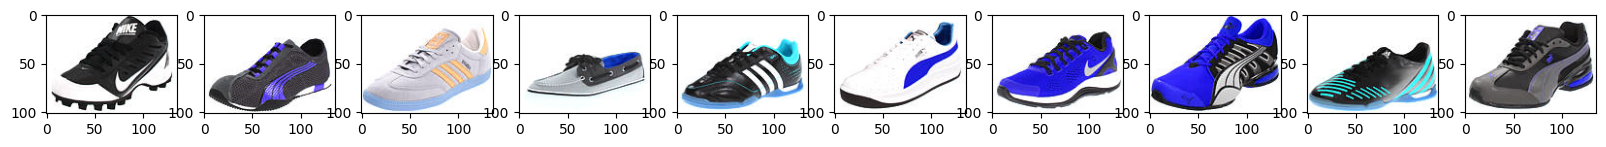

La clase Boot contiene 5000 imágenes.
Las dimensiones de referencia para la clase Boot son: 102 x 136.


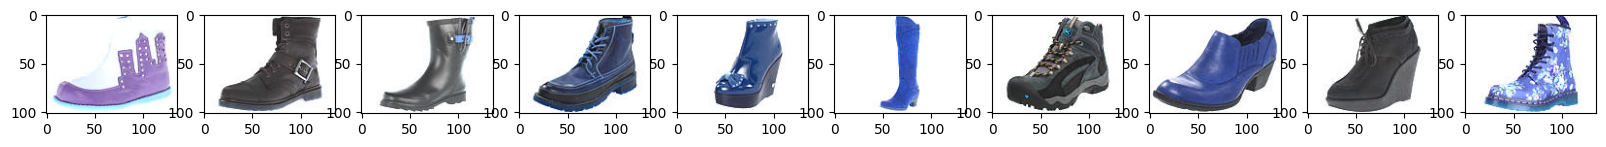

La clase Sandal contiene 5000 imágenes.
Las dimensiones de referencia para la clase Sandal son: 102 x 136.
Aviso: Sandal - Sandal (28).jpg tiene dimensiones diferentes: 102 x 135.
Aviso: Sandal - Sandal (91).jpg tiene dimensiones diferentes: 102 x 135.


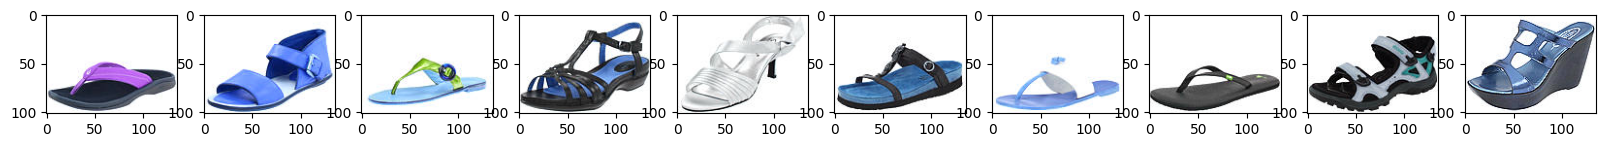

In [10]:
ruta_dataset    ='/content/my_dataset/Shoe vs Sandal vs Boot Dataset'
clases          = set( os.listdir( ruta_dataset ) )
mostrar         = 10
dims_diferentes = []

for clase in clases:
    ruta_clase  = os.path.join( ruta_dataset , clase )
    imagenes    = [ f for f in os.listdir( ruta_clase ) if f.endswith( '.jpg' ) ]
    n_imagenes  = len( imagenes )
    print( f'La clase { clase } contiene { n_imagenes } imágenes.' )

    # Read the dimensions of the first image in the class
    first_image_path = os.path.join( ruta_clase , imagenes[ 0 ] )
    first_image = cv2.imread( first_image_path )
    first_height , first_width , _ = first_image.shape
    print(f"Las dimensiones de referencia para la clase { clase } son: { first_height } x { first_width }.")

    # Check the dimensions of each image in the class
    for image_file in imagenes[ 1 : ]:
        image_path          = os.path.join ( ruta_clase , image_file )

        # Read the image using OpenCV
        img                 = cv2.imread( image_path )
        height , width , _  = img.shape

        # Compare dimensions with the first image
        if ( height , width ) != ( first_height , first_width ):
            print( f"Aviso: { clase } - { image_file } tiene dimensiones diferentes: { height } x { width }." )
            dims_diferentes.append( image_path )

    ejemplos    = random.choices( imagenes , k = mostrar )
    fig, axes   = plt.subplots( 1 , mostrar )
    fig.set_figwidth( 20 )

    for i , ejemplo in enumerate( ejemplos ):
        imagen    = cv2.imread( os.path.join( ruta_clase , ejemplo ) )
        axes[ i ].imshow( imagen )

    plt.show()

Para las dos imágenes que no siguen las dimensiones generales, se hace un resize para que también tengan dimensiones 136 x 102.

In [11]:
for imagen in dims_diferentes:
    img = cv2.imread(imagen)

    # Specify the target dimensions
    target_width, target_height = 136, 102

    # Resize the image using cv2.INTER_LINEAR interpolation
    resized_img = cv2.resize(img, (target_width, target_height), interpolation=cv2.INTER_LINEAR)

    # Save the resized image
    cv2.imwrite("path/to/your/resized_image.jpg", resized_img)

Tras inspeccionar el conjunto de datos disponible, se pueden sacar las siguientes conclusiones:


*   La cantidad de imágenes es lo suficientemente elevada para el entrenamiento de los modelos. En los datos de entrenamiento utilizaremos algunas técnicas de data augmentation
*   Las tres clases están perfectamente balanceadas, lo cual supondrá una ventaja a la hora del entrenamiento ya que están igualmente representadas.
*   Casi todas las imágenes vienen con las mismas dimensiones: 136 x 102. Las dos que tienen otras dimensiones solamente difieren por un pixel de ancho, por lo que se ha hecho un resize. La homogeneidad en las dimensiones también es un punto a favor para el entrenamiento del modelo.

> ### 1.3.  Acondicionamiento del conjunto de datos.

Se construyen a continuación las particiones de test, validation y train que se emplearán en los diferentes modelos.

En total, tendremos un 60% de datos de entrenamiento (9000 imágenes), 20% para validación y 20% para test (3000 en cada conjunto).

In [12]:
ruta_img    = os.path.join( "/content/my_dataset" , "img" )

train_dir   = os.path.join( ruta_img , "train"  )
val_dir     = os.path.join( ruta_img , "val"    )
test_dir    = os.path.join( ruta_img , "test"   )

for directory in [ train_dir , val_dir , test_dir ]:
    if not os.path.exists( directory ):
        os.makedirs( directory )

for clase in clases:
    train_class_dir = os.path.join( train_dir , clase )
    val_class_dir   = os.path.join( val_dir   , clase )
    test_class_dir  = os.path.join( test_dir  , clase )

    for class_directory in [ train_class_dir , val_class_dir , test_class_dir ]:
        if not os.path.exists( class_directory ):
            os.makedirs( class_directory )

    ruta_clase      = os.path.join( ruta_dataset , clase )
    imagenes        = [ f for f in os.listdir( ruta_clase ) if f.endswith( '.jpg' )]

    train_files_outer , test_files   = train_test_split( imagenes           , test_size = 0.2   , random_state = 42 )
    train_files_inner , val_files    = train_test_split( train_files_outer  , test_size = 0.25  , random_state = 42 )

    for file in train_files_inner:
        copyfile( os.path.join( ruta_clase , file ) , os.path.join( train_dir , clase , file ) )

    for file in val_files:
        copyfile( os.path.join( ruta_clase , file ) , os.path.join( val_dir   , clase , file ) )

    for file in test_files:
        copyfile( os.path.join( ruta_clase , file ) , os.path.join( test_dir  , clase , file ) )

## 2.  Estrategia 1: Entrenar desde cero o *from scratch*.

> ### 2.1.  Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución.

Se crean los ImageDataGenerator: uno para validación y test, donde solamente se hace una normalización, y otro para el entrenamiento, donde se hace data augmentation moviendo ligeramente las imágenes y haciendo zoom. Se descartó hacer flips y rotaciones debido a que, tras inspeccionar el conjunto de datos, se vio que todas las imágenes están en la misma orientación (hacia la izquierda) y sin rotaciones.

Para cargar los datos, utilizamos flow_from_directory, apuntando a cada una de las carpetas (train, val y test). Además, hacemos shuffle en entrenamiento y validación, para que las imágenes de cada batch vayan cambiando y no siempre sean los mismos batches, que también podría llevar a overfitting.

In [13]:
img_width, img_height = 136, 102
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalizamos los valores de los píxeles a valores [0,1]
)

datagen_augmented = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalizamos los valores de los píxeles a valores [0,1]
    width_shift_range=0.1, # Fracción del total (1) para mover la imagen
    height_shift_range=0.1, # Fracción del total (1) para mover la imagen
    zoom_range=0.1, # Rango de zoom
)

train_generator = datagen_augmented.flow_from_directory(
    os.path.join(ruta_img, 'train'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    os.path.join(ruta_img, 'val'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    os.path.join(ruta_img, 'test'),
    target_size=(img_width, img_height),
    batch_size=1,
    shuffle=False,
    class_mode=None
)

print("Class Indices:", train_generator.class_indices)
print("Class Indices:", val_generator.class_indices)
print("Class Indices:", test_generator.class_indices)

Found 9000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Class Indices: {'Boot': 0, 'Sandal': 1, 'Shoe': 2}
Class Indices: {'Boot': 0, 'Sandal': 1, 'Shoe': 2}
Class Indices: {'Boot': 0, 'Sandal': 1, 'Shoe': 2}


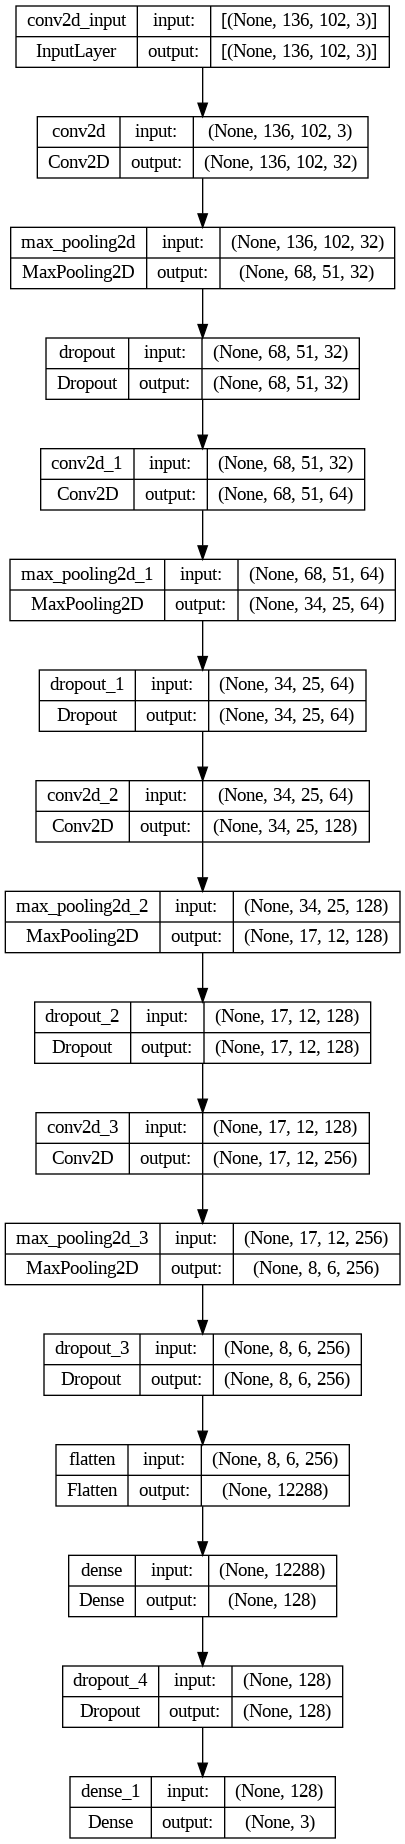

In [14]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(136, 102, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))  # Para las tres clases

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = val_generator.n // val_generator.batch_size
plot_model(model, show_shapes=True)

> ### 2.2.  Monitorización del proceso de entrenamiento para la toma de decisiones.

In [16]:
model_file = os.path.join("content/drive/MyDrive/Master/07MIAR/RNDP - Proyecto Programación Grupal", "from_scratch.h5" )
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights = False)
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

H = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=val_generator, validation_steps=STEP_SIZE_VALID, epochs=50, callbacks=[early_stop, checkpoint])

Epoch 1/50
281/281 [==============================] - ETA: 0s - loss: 0.3132 - accuracy: 0.8805
Epoch 1: val_loss improved from inf to 0.22277, saving model to content/drive/MyDrive/Master/07MIAR/RNDP - Proyecto Programación Grupal/from_scratch.h5
281/281 [==============================] - 48s 169ms/step - loss: 0.3132 - accuracy: 0.8805 - val_loss: 0.2228 - val_accuracy: 0.9194
Epoch 2/50
281/281 [==============================] - ETA: 0s - loss: 0.2329 - accuracy: 0.9127
Epoch 2: val_loss improved from 0.22277 to 0.18434, saving model to content/drive/MyDrive/Master/07MIAR/RNDP - Proyecto Programación Grupal/from_scratch.h5
281/281 [==============================] - 51s 181ms/step - loss: 0.2329 - accuracy: 0.9127 - val_loss: 0.1843 - val_accuracy: 0.9301
Epoch 3/50
281/281 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 0.9283
Epoch 3: val_loss improved from 0.18434 to 0.15336, saving model to content/drive/MyDrive/Master/07MIAR/RNDP - Proyecto Programación 

El entrenamiento del modelo se llevó a cabo empleando dos callbacks para la regularización y así evitar el overfitting:


*   **EarlyStopping**: con un patience = 3, paramos el entrenamiento si la métrica que seleccionamos (en este caso, la pérdida en validación), no mejora.
*   **ModelCheckpoint**: guardamos los pesos del mejor modelo en cuanto a pérdidas de validación. Se prefirió utilizar este callback y no el parámetro de restore_best_weights = True de EarlyStopping porque para el caso donde no se llega a las 3 épocas de patience, el modelo no guarda los mejores pesos.

En este caso, sí se llegó al límite de épocas de patience. El modelo dejó de mejorar la pérdida en validación en la época 11 (de un máximo de 50 que se fijaron).

El entrenamiento finalizó con una **pérdida de 0.0725 en validación y una accuracy de 97.51% en validación**.



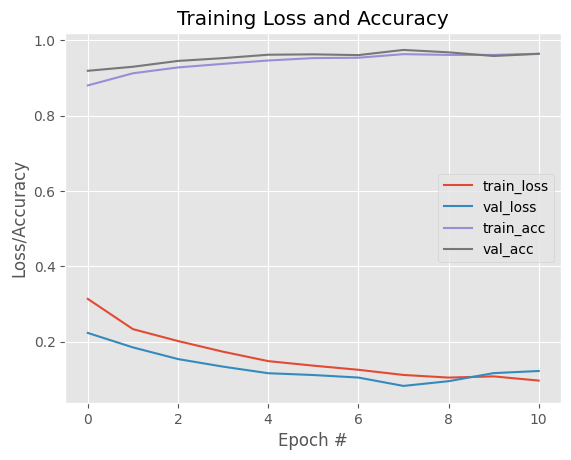

In [17]:
# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 11), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 11), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 11), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 11), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

> ### 2.3.  Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental.

In [18]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
test_generator.reset()
print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(test_generator, steps = STEP_SIZE_TEST, verbose = 1)
print(classification_report(test_generator.classes, predictions.argmax(axis = 1)))

[INFO]: Evaluando red neuronal...
3000/3000 [==============================] - 9s 3ms/step
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1000
           1       0.96      0.95      0.95      1000
           2       0.92      0.99      0.96      1000

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



La evaluación en el conjunto de test devolvió una **accuracy del 97%**.

Cabe destacar que, antes de seleccionar esta arquitectura, se hicieron otros experimentos que devolvieron resultados similares. Notablemente, también se consiguió un 97% de accuracy con una arquitectura más sencilla:

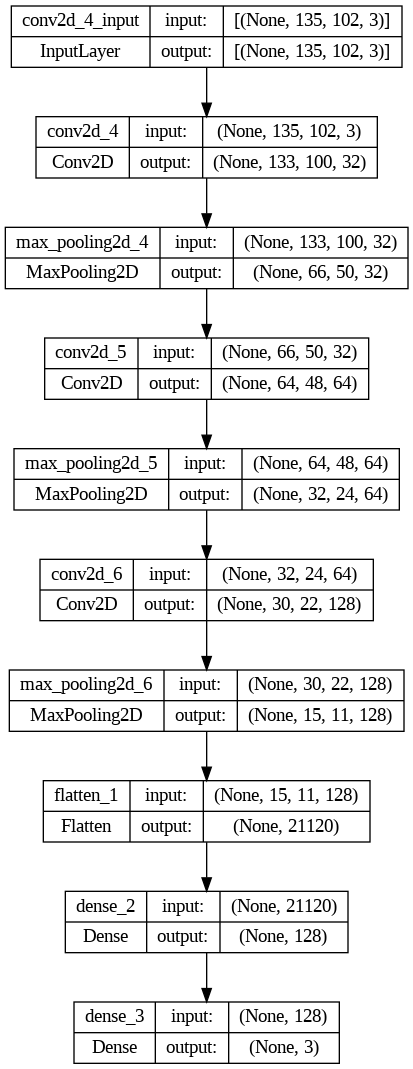

Sin embargo, con el fin de probar las capabilidades del Dropout y el Data Augmentation como técnicas de regularización, se decidió emplear la arquitectura descrita más arriba, obteniendo resultados similares en accuracy y mejores en pérdida.

Por otro lado, también es importante destacar que se ha probado una arquitectura que incluía capas de **BatchNormalization** entre las capas Conv2D y MaxPooling2D, aunque los resultados fueron inferiores a los conseguidos con el modelo presentado en este apartado. La curva de pérdida en validación no llegaba a converger, llegando a un máximo de 96% en accuracy pero después saltando a valores drásticamente inferiores.

Tras la arquitectura creada desde cero en esta sección, se explorarán algunas redes pre-entrenadas en el siguiente apartado.

## 3.  Estrategia 2: Red pre-entrenada.

> ### 3.1.  Arquitectura 1.

En este apartado se realizará un transfer learning del modelo EfficientNetV2L a esta clasificación

>> #### 3.1.1  Acondicionamiento del conjunto de datos.

Para esta arquitectura, el preprocesamiento y reescalado de las imágenes está incluído en las primeras capas del modelo, por lo que no es necesaria normalización de reescalado. Por tanto, el data generator aquí será ligeramente diferente al empleado en el apartado anterior.

In [19]:
# https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

# Define image dimensions and batch size
img_width , img_height  = 136 , 102
batch_size              = 32

# Create an ImageDataGenerator for data augmentation and normalization
# Se quita la normalización del pixel porque este modelo espera imágenes sobre 255.
datagen                 = ImageDataGenerator(
                                              # shear_range=0.2,
                                              # zoom_range=0.2,
                                              # horizontal_flip=True
                                            )

datagen_augmented       = ImageDataGenerator( width_shift_range   = 0.1 # Fracción del total (1) para mover la imagen
                                            , height_shift_range  = 0.1 # Fracción del total (1) para mover la imagen
                                            , zoom_range          = 0.1 # Rango de zoom
)

# Use the flow_from_directory method to load data
# El target_size se conserva porque por defecto transforma a 256x256
train_generator         = datagen_augmented.flow_from_directory(  os.path.join( ruta_img , 'train'  )
                                                                , target_size = ( img_width , img_height )
                                                                , batch_size  = batch_size
                                                                , shuffle     = True
                                                                , seed        = 42
                                                                , class_mode  = 'categorical'
                                                                )

# Use the flow_from_directory method to load data
val_generator           = datagen.flow_from_directory(  os.path.join( ruta_img , 'val'    )
                                                      , target_size = ( img_width , img_height )
                                                      , batch_size  = batch_size
                                                      , shuffle     = True
                                                      , seed        = 42
                                                      , class_mode  = 'categorical'
                                                      )

# Use the flow_from_directory method to load data
test_generator          = datagen.flow_from_directory(  os.path.join( ruta_img , 'test'   )
                                                      , target_size = ( img_width , img_height )
                                                      , batch_size  = 1
                                                      , shuffle     = False
                                                      , class_mode  = None
                                                      )

# Check the class indices
print( "Class Indices:" , train_generator.class_indices )
# Check the class indices
print( "Class Indices:" , val_generator.class_indices   )
# Check the class indices
print( "Class Indices:" , test_generator.class_indices  )

Found 9000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Class Indices: {'Boot': 0, 'Sandal': 1, 'Shoe': 2}
Class Indices: {'Boot': 0, 'Sandal': 1, 'Shoe': 2}
Class Indices: {'Boot': 0, 'Sandal': 1, 'Shoe': 2}


>> #### 3.1.2.  Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución.

In [20]:
base_model  = efficientnet_v2.EfficientNetV2L(  weights     = 'imagenet'
                                              , include_top = False
                                              , input_shape = ( img_height , img_width , 3 )
                                              )
base_model.summary()

473176280/473176280 [==============================] - 25s 0us/step
Model: "efficientnetv2-l"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 102, 136, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 102, 136, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 51, 68, 32)           864       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 51, 68, 32)           128       ['stem_conv[0][0]']           
 n)            

In [21]:
# Conectarlo a nueva parte densa para distinguir las 3 clases.
base_model.trainable  = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model     = Sequential()

pre_trained_model.add( base_model )
pre_trained_model.add( layers.Flatten() )
pre_trained_model.add( layers.Dense( len( clases )  , activation = 'softmax' ) )

pre_trained_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Function  (None, 4, 5, 1280)        117746848 
 al)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 25600)             0         
                                                                 
 dense_2 (Dense)             (None, 3)                 76803     
                                                                 
Total params: 117823651 (449.46 MB)
Trainable params: 76803 (300.01 KB)
Non-trainable params: 117746848 (449.17 MB)
_________________________________________________________________


In [22]:
# Compile the model
pre_trained_model.compile( optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = [ 'accuracy' ] )

# Train the model using the train_generator
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = val_generator.n   // val_generator.batch_size

>> #### 3.1.3.  Monitorización del proceso de entrenamiento para la toma de decisiones.

In [23]:
H_pretrain_arq1 = pre_trained_model.fit( train_generator , steps_per_epoch = STEP_SIZE_TRAIN , validation_data = val_generator , validation_steps = STEP_SIZE_VALID , epochs = 10 )

Epoch 1/10
281/281 [==============================] - 122s 316ms/step - loss: 0.3048 - accuracy: 0.9190 - val_loss: 0.2505 - val_accuracy: 0.9489
Epoch 2/10
281/281 [==============================] - 76s 270ms/step - loss: 0.1527 - accuracy: 0.9564 - val_loss: 0.1533 - val_accuracy: 0.9634
Epoch 3/10
281/281 [==============================] - 77s 272ms/step - loss: 0.1706 - accuracy: 0.9566 - val_loss: 0.1506 - val_accuracy: 0.9698
Epoch 4/10
281/281 [==============================] - 81s 289ms/step - loss: 0.1327 - accuracy: 0.9663 - val_loss: 0.1106 - val_accuracy: 0.9758
Epoch 5/10
281/281 [==============================] - 82s 292ms/step - loss: 0.1408 - accuracy: 0.9667 - val_loss: 0.0878 - val_accuracy: 0.9782
Epoch 6/10
281/281 [==============================] - 78s 277ms/step - loss: 0.1308 - accuracy: 0.9664 - val_loss: 0.1874 - val_accuracy: 0.9627
Epoch 7/10
281/281 [==============================] - 82s 293ms/step - loss: 0.1087 - accuracy: 0.9744 - val_loss: 0.1527 - val_a

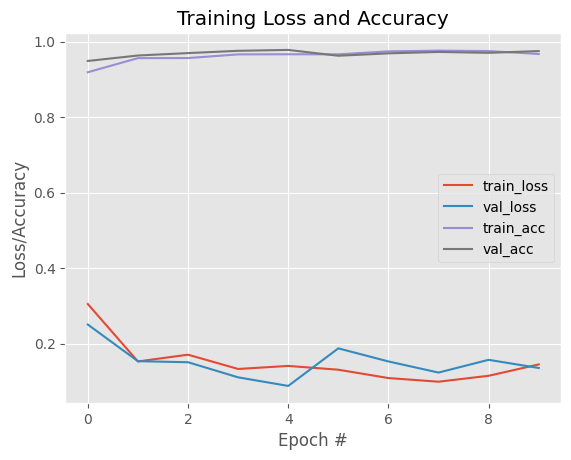

In [24]:
# Gráficas
plt.style.use( "ggplot" )
plt.figure()
plt.plot( np.arange( 0 , 10 ) , H_pretrain_arq1.history[ "loss"         ] , label = "train_loss"  )
plt.plot( np.arange( 0 , 10 ) , H_pretrain_arq1.history[ "val_loss"     ] , label = "val_loss"    )
plt.plot( np.arange( 0 , 10 ) , H_pretrain_arq1.history[ "accuracy"     ] , label = "train_acc"   )
plt.plot( np.arange( 0 , 10 ) , H_pretrain_arq1.history[ "val_accuracy" ] , label = "val_acc"     )
plt.title( "Training Loss and Accuracy" )
plt.xlabel( "Epoch #" )
plt.ylabel( "Loss/Accuracy" )
plt.legend()
plt.show()

>> #### 3.1.4.  Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental.

In [25]:
pre_trained_model.save( os.path.join( BASE_FOLDER , "pretrain_arq1_EfficientNetV2L.h5" ) )
# tf.saved_model.save( pre_trained_model , os.path.join( BASE_FOLDER , "pretrain_arq1_EfficientNetV2L" ) )

STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
test_generator.reset()

# Evaluación del modelo
print( "[INFO]: Evaluando el modelo..." )
predictions = pre_trained_model.predict( test_generator , steps = STEP_SIZE_TEST , verbose = 1 )
# Sacamos el report para test
print( classification_report( test_generator.classes , predictions.argmax( axis = 1 ) ) )

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[INFO]: Evaluando el modelo...
3000/3000 [==============================] - 151s 47ms/step
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1000
           1       0.98      0.98      0.98      1000
           2       0.94      1.00      0.97      1000

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



Da la impresión de que el modelo esté sufriendo de overfitting. Seguramente sería conveniente dar mayor variabilidad a los datos modificando los parámetros del data generator. Además, se pueden introducir estrategias de early stopping con checkpoints

> ### 3.2.  Arquitectura 2.

En este apartado se realizará un transfer learning del modelo ResNet50 a esta clasificación

>> #### 3.2.1  Acondicionamiento del conjunto de datos.

Se usan los mismos datos de input que el modelo desde cero para comparar los diferentes modelos.

>> #### 3.2.2.  Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución.

In [26]:
# Crear el modelo ResNet50 preentrenado
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(102, 136, 3))

# Crear un nuevo modelo sobre la base de ResNet50
modelResNet50 = Sequential()

# Añadir la base ResNet50 al nuevo modelo
modelResNet50.add(base_model)

# Añadir capas adicionales para adaptar el modelo a tus necesidades
modelResNet50.add(GlobalAveragePooling2D())
modelResNet50.add(Dense(1024, activation='relu'))
modelResNet50.add(Dense(3, activation='softmax'))  # 3 clases de salida

# Compilar el modelo
modelResNet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Imprimir la arquitectura del modelo
modelResNet50.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_4 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 25688963 (98.00 MB)
Trainable params: 25635843 (97.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [27]:
# Train the model using the train_generator
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = val_generator.n // val_generator.batch_size

# Ejecutar el modelo, tarda unos 9 minutos para las 10 épocas
mRN50 = modelResNet50.fit(train_generator,
          steps_per_epoch=STEP_SIZE_TRAIN,
          epochs= 10,
          validation_data=val_generator,
          validation_steps=STEP_SIZE_VALID)

Epoch 1/10
281/281 [==============================] - 103s 236ms/step - loss: 0.3156 - accuracy: 0.9118 - val_loss: 0.4184 - val_accuracy: 0.8696
Epoch 2/10
281/281 [==============================] - 62s 220ms/step - loss: 0.1199 - accuracy: 0.9607 - val_loss: 3.2072 - val_accuracy: 0.6731
Epoch 3/10
281/281 [==============================] - 64s 226ms/step - loss: 0.0964 - accuracy: 0.9691 - val_loss: 0.2407 - val_accuracy: 0.9126
Epoch 4/10
281/281 [==============================] - 62s 221ms/step - loss: 0.0824 - accuracy: 0.9726 - val_loss: 0.2034 - val_accuracy: 0.9382
Epoch 5/10
281/281 [==============================] - 62s 219ms/step - loss: 0.0737 - accuracy: 0.9738 - val_loss: 0.2565 - val_accuracy: 0.9298
Epoch 6/10
281/281 [==============================] - 62s 220ms/step - loss: 0.0626 - accuracy: 0.9796 - val_loss: 0.6497 - val_accuracy: 0.7776
Epoch 7/10
281/281 [==============================] - 62s 219ms/step - loss: 0.0571 - accuracy: 0.9807 - val_loss: 0.3696 - val_a

>> #### 3.2.3.  Monitorización del proceso de entrenamiento para la toma de decisiones.

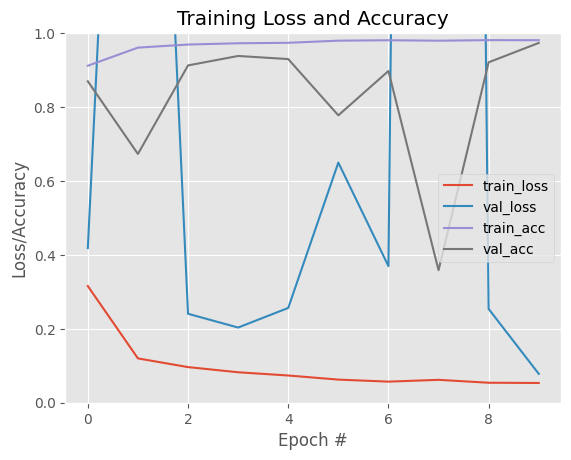

In [30]:
# Mostrar gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, 10), mRN50.history["loss"], label="train_loss")
plt.plot(np.arange(0, 10), mRN50.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 10), mRN50.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 10), mRN50.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.ylim(0, 1)
plt.legend(loc='right')

>> #### 3.2.4.  Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental.

In [31]:
#Evaluar modelo
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
test_generator.reset()
print("[INFO]: Evaluando red neuronal...")
predictions = modelResNet50.predict(test_generator, steps = STEP_SIZE_TEST, verbose = 1)
print(classification_report(test_generator.classes, predictions.argmax(axis = 1)))

[INFO]: Evaluando red neuronal...
3000/3000 [==============================] - 32s 10ms/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1000
           1       0.96      0.98      0.97      1000
           2       0.98      0.94      0.96      1000

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



## 4.  Generación de documento PDF a partir del Colab Notebook (fichero ".ipynb").

In [32]:
name_IPYNB_file = 'RNDP - Proyecto Programación Grupal.ipynb'
get_ipython().system(
        "apt update >> /dev/null && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended >> /dev/null"
                    )
get_ipython().system(
            "jupyter nbconvert --output-dir='$BASE_FOLDER' '$BASE_FOLDER''$name_IPYNB_file' --to pdf"
                    )





E: Unable to locate package texlive-generic-recommended
[NbConvertApp] WARNING | pattern '$BASE_FOLDER$name_IPYNB_file' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of pro